# INVICTA Spring School
# Training Spiking Neural Networks
### Written by Jason Eshraghian

What you will learn:
* Learn how spiking neurons are implemented as a recurrent network
* Train a fully-connected SNN on the static MNIST dataset
* Download event-based data and train a convolutional SNN with it

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [ ]:
!pip install snntorch # install snntorch
!pip install torchvision

## 1. Imports

In [3]:
# imports
import snntorch as snn

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 2. Setting up the Static MNIST Dataset


In [4]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [6]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 3. Define the Network

In [7]:
# Network Architecture
num_inputs = 28 * 28  # number of inputs
num_hidden = 1000  # number of hidden neurons
num_outputs = 10 # number of classes (i.e., output neurons)

# Temporal Dynamics
num_steps = 25

In the following code-block, note how the decay rate `beta` has two alternative definitions:
* `beta1` is set to a global decay rate for all neurons in the first spiking layer.
* `beta2` is randomly initialized to a vector of 10 different numbers. Each spiking neuron in the output layer (which not-so-coincidentally has 10 neurons) therefore has a unique, and random, decay rate.

In [9]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()


        beta1 = 0.9 # global decay rate for all leaky neurons in layer 1
        beta2 = torch.rand((num_outputs), dtype = torch.float) # independent decay rate for each leaky neuron in layer 2: [0, 1)

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1) # not a learnable decay rate
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, learn_beta=True) # learnable decay rate

    def forward(self, x):
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0

        spk2_rec = [] # record output spikes
        mem2_rec = [] # record output hidden states

        for step in range(num_steps): # loop over time
            cur1 = self.fc1(x.flatten(1))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2) # record spikes
            mem2_rec.append(mem2) # record membrane

        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

A 'biophysical' interpretation is that `fc1` and `fc2` generate current injections that are fed into a set of $1,000$ and $10$ spiking neurons in `lif1` and `lif2`, respectively.

> Note: the number of spiking neurons is automatically inferred by the dimensionality of the dimensions of the current injection value.

## 4. Training the SNN

### 4.1 Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [10]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 4.2 Loss Definition
The `nn.CrossEntropyLoss` function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.

In [11]:
loss = nn.CrossEntropyLoss()

## 4.3 Optimizer
Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of $5\times10^{-4}$.

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 4.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [13]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

Flatten the input data to a vector of size $784$ and pass it into the network.

In [14]:
spk_rec, mem_rec = net(data)
print(mem_rec.size())

torch.Size([25, 128, 10])


The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together:


$$\mathcal{L}_{Total-CE} = \sum_t\mathcal{L}_{CE}[t]$$

In [15]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 58.447


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around 10%) as the network is untrained:

In [16]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 11.72%


A single weight update is applied to the network as follows:

In [17]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [18]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data)

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 53.360
Train set accuracy for a single minibatch: 17.19%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6 in the snnTorch docs](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 4.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [19]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 55.06
Test Set Loss: 51.79
Train set accuracy for a single minibatch: 15.62%
Test set accuracy for a single minibatch: 17.19%


Epoch 0, Iteration 50
Train Set Loss: 16.87
Test Set Loss: 16.24
Train set accuracy for a single minibatch: 79.69%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 100
Train Set Loss: 8.08
Test Set Loss: 10.25
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 150
Train Set Loss: 11.28
Test Set Loss: 9.56
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 200
Train Set Loss: 4.35
Test Set Loss: 9.19
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 83.59%


Epoch 0, Iteration 250
Train Set Loss: 4.90
Test Set Loss: 5.53
Train set accuracy for a single minibatch: 96.88%
Test set accuracy for a single minibatch: 92.19%


Epoch 0

KeyboardInterrupt: 

If this was your first time training an SNN, then congratulations. I'm proud of you and I always believed in you.

# 5. Results
## 5.1 Plot Training/Test Loss

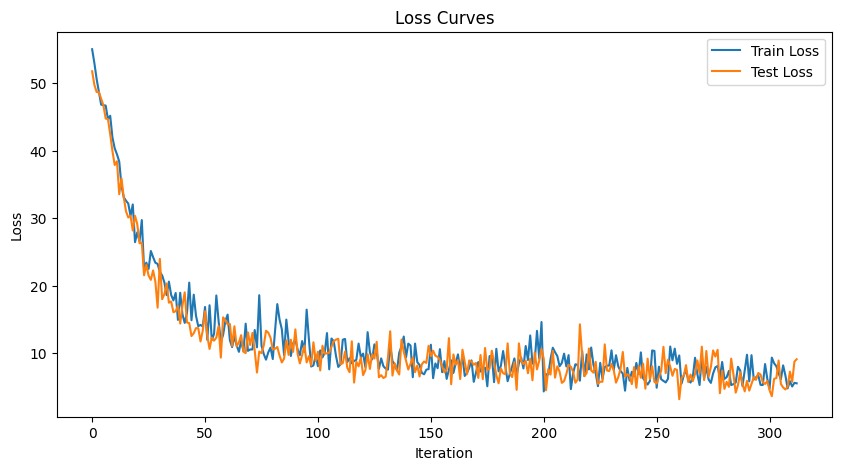

In [20]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

## 5.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [21]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9320/10000
Test Set Accuracy: 93.20%


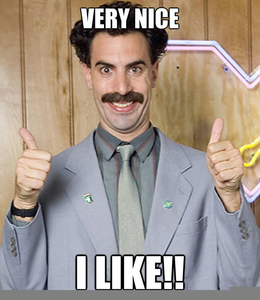

In [23]:
#@title Run this block for a good time
import requests
from IPython.display import Image, display

def display_image_from_url(url):
    response = requests.get(url, stream=True)
    display(Image(response.content))

url = "http://www.clker.com/cliparts/7/8/a/0/1498553633398980412very-nice-borat.med.png"
display_image_from_url(url)

# 6. Handling Neuromorphic Data with Tonic

In [22]:
!pip install tonic --quiet

## 3.1 PokerDVS Dataset

The dataset used in this tutorial is POKERDVS by T. Serrano-Gotarredona and B. Linares-Barranco:

```
Serrano-Gotarredona, Teresa, and Bernabé Linares-Barranco. "Poker-DVS and MNIST-DVS. Their history, how they were made, and other details." Frontiers in neuroscience 9 (2015): 481.
```

It is comprised of four classes, each being a suite of a playing card deck: clubs, spades, hearts, and diamonds. The data consists of 131 poker pip symbols, and was collected by flipping poker cards in front of a DVS128 camera.

/home/joel/PhD/.envs/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


700416it [00:01, 686625.55it/s]                             


Extracting ./data/POKERDVS/pips_train.tar.gz to ./data/POKERDVS


311296it [00:00, 1114906.25it/s]                           
/tmp/ipykernel_12797/1180474003.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tonic.utils.plot_event_grid(events)


Extracting ./data/POKERDVS/pips_test.tar.gz to ./data/POKERDVS
[(    0, 20, 21, 0) (  106, 21, 19, 0) (  146, 13,  9, 1) ...
 (15365, 13, 17, 1) (15384, 16, 16, 1) (15408, 16, 22, 0)]


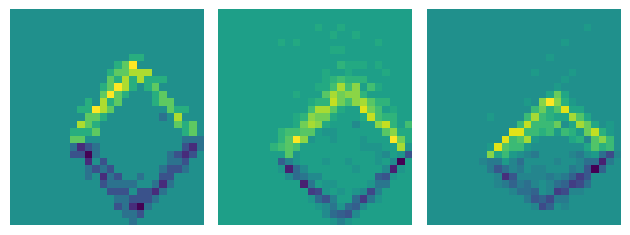

In [24]:
import tonic

poker_train = tonic.datasets.POKERDVS(save_to='./data', train=True)
poker_test = tonic.datasets.POKERDVS(save_to='./data', train=False)

events, target = poker_train[0]
print(events)
tonic.utils.plot_event_grid(events)

In [25]:
import tonic.transforms as transforms
from tonic import DiskCachedDataset

# time_window
frame_transform = tonic.transforms.Compose([tonic.transforms.Denoise(filter_time=10000),
                                            tonic.transforms.ToFrame(
                                            sensor_size=tonic.datasets.POKERDVS.sensor_size,
                                            time_window=1000) # 1ms at a time
                                            ])

batch_size = 8
cached_trainset = DiskCachedDataset(poker_train, transform=frame_transform, cache_path='./cache/pokerdvs/train')
cached_testset = DiskCachedDataset(poker_test, transform=frame_transform, cache_path='./cache/pokerdvs/test')

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

data, labels = next(iter(train_loader))
print(data.size())
print(labels)

torch.Size([25, 8, 2, 35, 35])
tensor([2, 2, 0, 3, 3, 1, 3, 0])


In [26]:
import torch.functional as F

# Define Network
class DVSNet(nn.Module):
    def __init__(self):
        super().__init__()

        beta = 0.9

        # Initialize layers
        self.conv1  = nn.Conv2d(2, 12, 5)
        self.mp1    = nn.MaxPool2d(2)
        self.lif1   = snn.Leaky(beta=beta)
        self.conv2  = nn.Conv2d(12, 32, 5)
        self.mp2    = nn.MaxPool2d(2)
        self.lif2   = snn.Leaky(beta=beta)
        self.fc     = nn.Linear(32*5*5, 4)
        self.lif3   = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(x.size(0)):
            cur1       = self.mp1(self.conv1(x[step]))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2       = self.mp2(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3       = self.fc(spk2.flatten(1))
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Load the network onto CUDA if available
dvsnet = DVSNet().to(device)

In [27]:
def training_loop(model, dataloader, num_epochs=1):
  loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))
  counter = 0

  # Outer training loop
  for epoch in range(num_epochs):
      train_batch = iter(dataloader)

      # Minibatch training loop
      for data, targets in train_batch:
          data = data.to(device)
          targets = targets.to(device)

          # forward pass
          model.train()
          spk_rec, _ = model(data)

          # initialize the loss & sum over time
          loss_val = torch.zeros((1), dtype=dtype, device=device)
          loss_val = loss(spk_rec.sum(0), targets) # batch x num_out

          # Gradient calculation + weight update
          optimizer.zero_grad()
          loss_val.backward()
          optimizer.step()

          # Print train/test loss/accuracy
          if counter % 10 == 0:
              print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
          counter += 1

          if counter == 100:
            break

training_loop(dvsnet, train_loader)

Iteration: 0 	 Train Loss: 1.3862943649291992


In [28]:
def measure_accuracy(model, dataloader):
  with torch.no_grad():
    model.eval()
    running_length = 0
    running_accuracy = 0

    for data, targets in iter(dataloader):
      data = data.to(device)
      targets = targets.to(device)

      # forward-pass
      spk_rec, _ = model(data)
      spike_count = spk_rec.sum(0) # batch x num_outputs
      _, max_spike = spike_count.max(1)

      # correct classes for one batch
      num_correct = (max_spike == targets).sum()

      # total accuracy
      running_length += len(targets)
      running_accuracy += num_correct

    accuracy = (running_accuracy / running_length)

    return accuracy.item()


In [29]:
training_loop(dvsnet, train_loader, num_epochs=10)
print(f"Test set accuracy: {measure_accuracy(dvsnet, test_loader)}")

Iteration: 0 	 Train Loss: 1.3059661388397217
Iteration: 10 	 Train Loss: 0.5096333026885986
Iteration: 20 	 Train Loss: 0.2335098683834076
Iteration: 30 	 Train Loss: 0.10987869650125504
Iteration: 40 	 Train Loss: 0.3717549443244934
Iteration: 50 	 Train Loss: 0.07290800660848618
Test set accuracy: 1.0


# Conclusion

That covers how to train a spiking neural network. There are a lot of ways to alter this, e.g., by using different neuron models, surrogate gradients, learnable beta and threshold values, or modifying the fully-connected layers by replacing them with convolutions or whatever else you fancy.